In [3]:
from slda.topic_models import SLDA
from slda.topic_models import BLSLDA
from functools import partial
from sklearn.metrics import (mean_squared_error)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import fnmatch
import re
import random
from scipy import sparse
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from math import ceil
from pandas import get_dummies
from __future__ import division
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.linear_model import LogisticRegression

## BLSLDA SLDA LIBraray depends on Conda software

# binary logistic supervised latent Dirichlet allocation for predic nagative and positive sentiment

In [36]:
df=pd.DataFrame(columns=['Name', 'Publisher', 'GameSpotScore', 'Review', 'Console', 'Genre', 'Class'])

## IO FILE DUMP

In [41]:
i=0
for dirpath, dirs, files in os.walk('dataset/reviews'):   
    for file in fnmatch.filter(files, '*.txt'):
        with open(os.path.join(dirpath, file), 'r') as ip:
            data=ip.read()
            name=re.findall(r':::Game Name:::(.*?)-----', data, re.DOTALL)[0].strip()
            review=re.findall(r':::Review:::(.*?)-----',data, re.DOTALL)[0].strip()
            scores=re.findall(r':::Scores:::(.*?)-----',data, re.DOTALL)[0]
            addition=re.findall(r':::Addition:::(.*?)-----',data, re.DOTALL)[0]
            gsScore=re.findall(r'GameSpot Score:(.*?)\n', scores)[0]
            if(float(gsScore)>=5):
                cls=1
            else:
                cls=0
            try:
                pub=re.findall(r'Publisher:(.*?)\n', addition)[0]
            except:
                pub=''
            try:
                genre=re.findall(r'Genre:(.*?)\n', addition)[0]
            except:
                genre=''
            console=dirpath.strip('dataset/reviews/')
            df.loc[i]=[name, pub, gsScore, review, console, genre, cls]
            i+=1
            

In [42]:
def extractmx(inputmat,indices):
    output = np.empty((0, np.shape(inputmat)[1]))
    for index in indices:
        vec=inputmat[index]
        output=np.append(output, vec, axis=0)
    return output   

# subset the trainning and testing data

In [43]:
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=0.2,max_features=1000,stop_words='english', lowercase=True)
inputbackwords = tf_vectorizer.fit_transform(df['Review'])
inputbackwords=inputbackwords.todense()
features= tf_vectorizer.get_feature_names()
train, test = train_test_split(df, test_size = 0.2)

trainvector = extractmx(inputbackwords,train.index)
trainvector = sparse.csr_matrix(trainvector, dtype='int')
testvector = extractmx(inputbackwords,test.index)
testvector = sparse.csr_matrix(testvector, dtype='int')

In [44]:
trainclass = train["Class"]
trainclass1 = list(trainclass) 
trainclass2 = np.array(trainclass)

K=25
alpha = np.ones(K)
_K = 25
D=len(df)
V=len(features)
_alpha = alpha
_beta = np.repeat(0.01, V)
_mu = 0
_nu2 = 10
_b = 7.25
n_iter = 500
blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42)
blslda.fit(trainvector,trainclass2)

2017-04-18 19:34:01.664334 start iterations
2017-04-18 19:34:03.906782 0:00:02.242448 elapsed, iter   10, LL -715729.9301, 30.46% change from last
2017-04-18 19:34:06.422973 0:00:04.758639 elapsed, iter   20, LL -574105.1216, 19.79% change from last
2017-04-18 19:34:08.598078 0:00:06.933744 elapsed, iter   30, LL -520255.0462, 9.38% change from last
2017-04-18 19:34:10.622768 0:00:08.958434 elapsed, iter   40, LL -490216.7727, 5.77% change from last
2017-04-18 19:34:12.821736 0:00:11.157402 elapsed, iter   50, LL -474811.2169, 3.14% change from last
2017-04-18 19:34:14.742119 0:00:13.077785 elapsed, iter   60, LL -462620.1162, 2.57% change from last
2017-04-18 19:34:16.601983 0:00:14.937649 elapsed, iter   70, LL -456508.6627, 1.32% change from last
2017-04-18 19:34:18.549270 0:00:16.884936 elapsed, iter   80, LL -449835.1413, 1.46% change from last
2017-04-18 19:34:20.639922 0:00:18.975588 elapsed, iter   90, LL -447277.8787, 0.57% change from last
2017-04-18 19:34:23.059453 0:00:21.3

In [45]:
# Trained model
blslda

BLSLDA(alpha=array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
    b=7.25, beta=array([ 0.01,  0.01, ...,  0.01,  0.01]), mu=0,
    n_iter=500, n_report_iter=10, n_topics=25, nu2=10, seed=42)

In [46]:
# Set the paramenter 
def bern_param(eta, theta):
    return np.exp(np.dot(eta, theta)) / (1 + np.exp(np.dot(eta, theta)))

burn_in = max(500 - 100, int(500 / 2))
eta_pred = blslda.eta[burn_in:].mean(axis=0)
lglk=blslda.loglikelihoods[burn_in:].mean()
eta_pred = blslda.eta[burn_in:].mean(axis=0)
test_blslda = blslda.transform(testvector)
y_blslda = [bern_param(eta_pred, test_blslda[i]) for i in range(len(test))]

# RMSE evaluation

In [47]:
def RMSE(A,B):
    sse=0
    n=len(A)
    for a, b in zip(A, B):
        sse+=(a-b)**2
    rmse=(sse/n)**2
    return rmse

rmse=RMSE(test['Class'], y_blslda)
print(rmse)

0.0115604278447


In [50]:
y_blslda1 = y_blslda

In [51]:
for i in range(len(y_blslda1)):
    if y_blslda1[i]>=0.5:
        y_blslda1[i] = 1
    else:
        y_blslda1[i]=0
        

# Compare with initial label, the accuracy rate is 88%

In [53]:
def valid(x,y):
    count = 0 
#     print(len(x))
    for i in range(len(x)):
        if x[i] == y[i]:
            count = count + 1
#             print(count)
    vc = count/len(y)
    return vc


valid(y_blslda1,test["Class"].values)

0.8817204301075269

# Elvaluation ROC CURVE

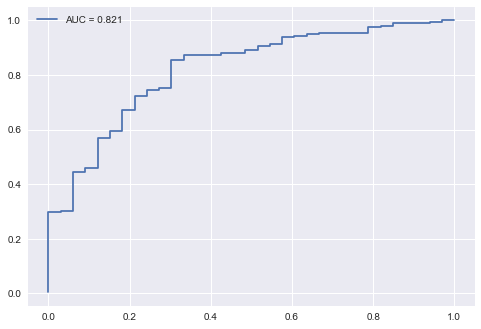

In [49]:
from sklearn.metrics import (roc_auc_score, roc_curve)
fpr, tpr, _ = roc_curve(test['Class'], y_blslda)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(test['Class'], y_blslda))))
_ = plt.legend(loc='best')
plt.show()

# likelyhoods

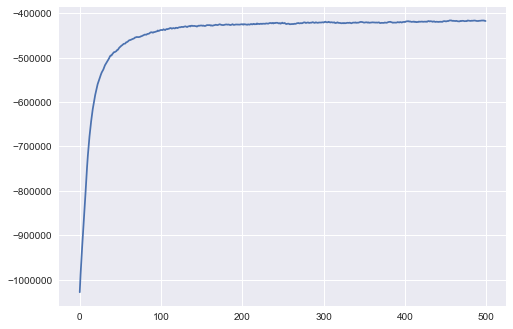

In [16]:
plt.plot(blslda.loglikelihoods)
plt.show()

# Learned Topics for DataSet

In [121]:
 def topics(model):   
    for topic in model.phi:
        topProbs=sorted(topic, reverse=True)[:10]
        indices=[]
        topWords=[]
        for prob in topProbs:
            i=np.where(topic==prob)
            for index in i[0]:
                indices.append(int(index))
            indices=indices[:10]
        for i in indices:
            topWords.append(features[i])
            
        print(topWords)
        
topics(blslda)

['mode', 'player', 'single', 'multiplayer', 'players', 'online', 'modes', 'different', 'score', 'features']
['speed', 'track', 'events', 'need', 'course', 'line', 'feel', 'rate', 'variety', 'don']
['360', 'xbox', 'version', 'versions', 'playstation', 'online', 'way', 'look', 'looks', 'good']
['power', 'challenge', 'good', 'fun', 'gameplay', 'difficulty', 'score', 'style', 'easy', 'end']
['psp', 'games', 'version', 'console', 'versions', 'mode', 'good', 'playstation', 'available', 'times']
['want', 've', 'great', 'need', 'don', 'people', 'won', 'way', 'place', 'life']
['bit', 'things', 'actually', 'isn', 'big', 'quite', 'thing', 'does', 'kind', 'really']
['new', 'series', 'games', 'previous', 'bit', 'years', 'great', 'fans', 've', 'addition']
['points', 'games', 'earn', 'hit', 'playing', 'start', 'open', 'point', 'basic', 'try']
['characters', 'character', 'story', 'attacks', 'special', 'dialogue', 'attack', 'voice', 'playing', 'fighting']
['number', 'gameplay', 'feel', 'way', 'makes', 

# supervised latent Dirichlet allocation for predic nagative and positive sentiment

In [116]:
def imSLDA(classlabels,df,features): 
    _K = 25
    alpha = np.ones(K)
    _alpha = alpha
    V=len(features)
    _beta = np.repeat(0.01, V)
    _mu = 0
    _nu2 = 10
    _sigma2 = 1
    n_iter = 500
    slda = SLDA(_K, _alpha, _beta, _mu, _nu2, _sigma2, n_iter, seed=42)
    slda.fit(df, classlabels)
    return slda

slda=imSLDA(trainclass2,trainvector,features)

2017-04-16 20:12:00.257074 start iterations
2017-04-16 20:12:02.236663 0:00:01.979589 elapsed, iter   10, LL -717768.8829, 30.46% change from last
2017-04-16 20:12:04.028071 0:00:03.770997 elapsed, iter   20, LL -581898.7021, 18.93% change from last
2017-04-16 20:12:05.777050 0:00:05.519976 elapsed, iter   30, LL -524840.1511, 9.81% change from last
2017-04-16 20:12:07.601195 0:00:07.344121 elapsed, iter   40, LL -494804.1631, 5.72% change from last
2017-04-16 20:12:09.355191 0:00:09.098117 elapsed, iter   50, LL -476658.5945, 3.67% change from last
2017-04-16 20:12:11.095944 0:00:10.838870 elapsed, iter   60, LL -463298.9528, 2.80% change from last
2017-04-16 20:12:12.860213 0:00:12.603139 elapsed, iter   70, LL -456552.9787, 1.46% change from last
2017-04-16 20:12:14.598958 0:00:14.341884 elapsed, iter   80, LL -449007.5332, 1.65% change from last
2017-04-16 20:12:16.336957 0:00:16.079883 elapsed, iter   90, LL -443697.3450, 1.18% change from last
2017-04-16 20:12:18.076351 0:00:17.8

In [117]:
# slda.loglikelihoods[:].mean()
eta_pred = slda.eta[burn_in:].mean(axis=0)
test_slda = slda.transform(testvector)
y_slda = [np.dot(eta_pred, test_slda[i]) for i in range(len(test))]

In [120]:
rmse=RMSE(test['Class'], y_slda)
print(rmse)

0.00957932138119


In [122]:
topics(slda)

['mode', 'player', 'multiplayer', 'online', 'single', 'players', 'modes', 'score', 'include', 'features']
['speed', 'events', 'track', 'need', 'online', 'course', 'line', 'don', 'isn', 'fast']
['360', 'xbox', 'version', 'playstation', 'versions', 'way', 'live', 'good', 'looks', 'playing']
['really', 'pretty', 'good', 'different', 'lot', 'great', 'look', 'quite', 'looking', 'probably']
['mode', 'opponent', 'match', 'matches', 'opponents', 'fight', 'style', 'moves', 'fighting', 'create']
['need', 'want', 'fun', 'start', 'long', 'times', 'won', 'place', 'takes', 'short']
['games', 'playing', 'fun', 'lot', 'big', 'easy', 'great', 'better', 'makes', 'looking']
['new', 'series', 'previous', 'games', 'bit', 'addition', 'years', 'features', 'fans', 'head']
['ve', 'way', 'people', 'don', 'pick', 'look', 'good', 'run', 'probably', 'things']
['characters', 'character', 'story', 'use', 'dialogue', 'voice', 'adventure', 'playing', 'items', 'special']
['points', 'hit', 've', 'power', 'good', 'start'